# Cross-Model Embedding Comparison

This experiment explores the **shared embedding space** of Voyage 4 models.

**Key Questions:**
1. Are there consistent variations in embeddings generated by different models?
2. How does similarity score variation compare across models?
3. Do larger models produce more or less consistent embeddings?

**Models Tested (all Voyage 4 family):**
- `voyage-4-large` - Flagship, maximum accuracy (MoE architecture)
- `voyage-4` - General purpose, balanced
- `voyage-4-lite` - Lower latency, reduced compute
- `voyage-4-nano` - Lightweight, local development

## Setup

In [1]:
import json
import sys
import os
from pathlib import Path

NOTEBOOK_DIR = Path(os.path.dirname(os.path.abspath('__file__'))).resolve()
if NOTEBOOK_DIR.name == 'notebooks':
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

sys.path.insert(0, str(PROJECT_ROOT / 'src'))
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/edolsonmorgan/repos/shared-embeddings-space-experiments


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from embeddings_space.embeddings import EmbeddingsClient
from embeddings_space.metrics import pairwise_similarities, cosine_similarity
from embeddings_space.diversity import diversity_report

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## Load Coffee Paraphrases

In [3]:
with open(PROJECT_ROOT / 'data' / 'coffee_paraphrases.json', 'r') as f:
    coffee_data = json.load(f)

texts = coffee_data['coffee_paraphrases']
print(f"Loaded {len(texts)} coffee paraphrases")
print(f"Example: {texts[0][:80]}...")

Loaded 16 coffee paraphrases
Example: The perfect cup of coffee requires freshly ground beans and water heated to prec...


## Generate Embeddings with All Voyage 4 Models

In [4]:
# Voyage 4 family models (shared embedding space)
VOYAGE_4_MODELS = [
    "voyage-4-large",
    "voyage-4",
    "voyage-4-lite",
    "voyage-4-nano"
]

model_embeddings = {}
model_dims = {}

for model in VOYAGE_4_MODELS:
    print(f"Generating embeddings with {model}...")
    try:
        client = EmbeddingsClient(model=model)
        embeddings = client.embed_texts(texts)
        model_embeddings[model] = embeddings
        model_dims[model] = embeddings.shape[1]
        print(f"  ✓ Shape: {embeddings.shape}")
    except Exception as e:
        print(f"  ✗ Error: {e}")

print(f"\nSuccessfully generated embeddings for {len(model_embeddings)} models")

Generating embeddings with voyage-4-large...


  ✓ Shape: (16, 1024)
Generating embeddings with voyage-4...
  ✓ Shape: (16, 1024)
Generating embeddings with voyage-4-lite...


  ✓ Shape: (16, 1024)
Generating embeddings with voyage-4-nano...
  ✗ Error: Model voyage-4-nano is not supported. Supported models are ['voyage-4-large', 'voyage-4', 'voyage-4-lite', 'voyage-3', 'voyage-3-lite', 'voyage-finance-2', 'voyage-large-2-instruct', 'voyage-law-2', 'voyage-code-2', 'voyage-02', 'voyage-2', 'voyage-01', 'voyage-lite-01', 'voyage-lite-01-instruct', 'voyage-lite-02-instruct', 'voyage-code-3', 'voyage-3-large', 'voyage-3-5', 'voyage-3-5-lite', 'voyage-code-3-5', 'voyage-multilingual-2', 'voyage-large-2', 'voyage-3.5', 'voyage-3.5-lite', 'voyage-code-3.5'].

Successfully generated embeddings for 3 models


## Analysis 1: Embedding Dimension Comparison

In [5]:
print("Embedding Dimensions by Model:")
print("=" * 40)
for model, dim in model_dims.items():
    print(f"{model:20s}: {dim} dimensions")

Embedding Dimensions by Model:
voyage-4-large      : 1024 dimensions
voyage-4            : 1024 dimensions
voyage-4-lite       : 1024 dimensions


## Analysis 2: Within-Model Similarity Patterns

Compare how each model perceives similarity between the same paraphrases.

In [6]:
# Compute similarity matrices for each model
model_sim_matrices = {}
model_stats = []

for model, embeddings in model_embeddings.items():
    sim_matrix = pairwise_similarities(embeddings, metric="cosine")
    model_sim_matrices[model] = sim_matrix
    
    # Extract upper triangle (excluding diagonal)
    n = len(embeddings)
    upper_tri = sim_matrix[np.triu_indices(n, k=1)]
    
    model_stats.append({
        'Model': model,
        'Mean Similarity': np.mean(upper_tri),
        'Std Dev': np.std(upper_tri),
        'Min': np.min(upper_tri),
        'Max': np.max(upper_tri),
        'Range': np.max(upper_tri) - np.min(upper_tri)
    })

stats_df = pd.DataFrame(model_stats)
stats_df

,Model,Mean Similarity,Std Dev,Min,Max,Range
0,voyage-4-large,0.856654,0.032504,0.770651,0.917869,0.147217
1,voyage-4,0.898040,0.024386,0.820724,0.952472,0.131748
2,voyage-4-lite,0.875545,0.034257,0.786831,0.939055,0.152224


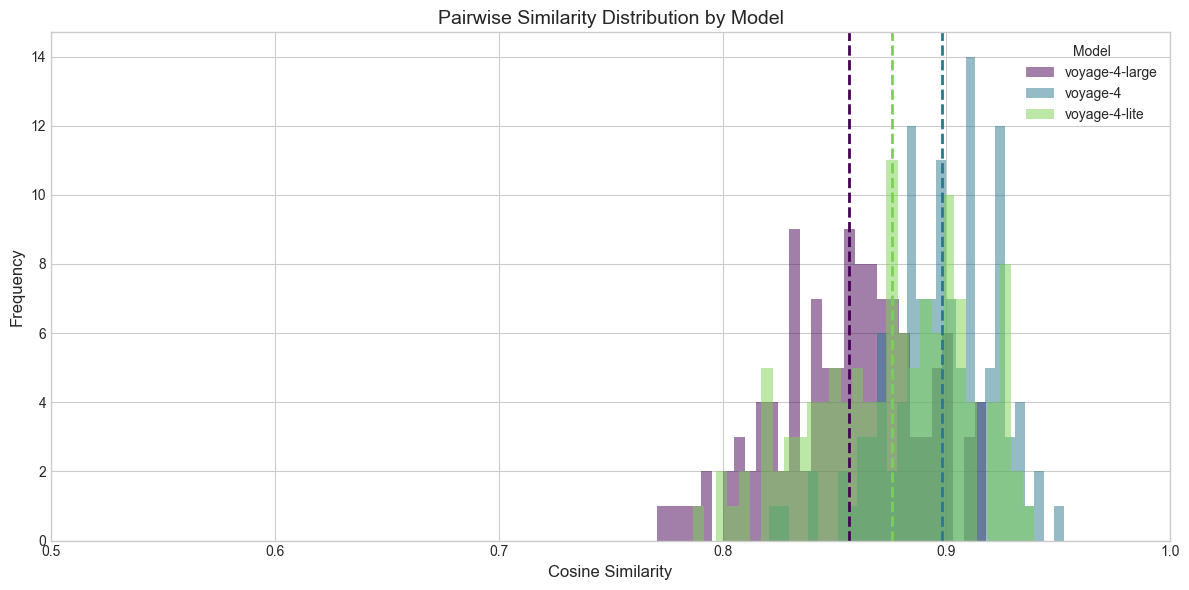

In [7]:
# Visualize similarity distributions by model
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(model_embeddings)))

for idx, (model, sim_matrix) in enumerate(model_sim_matrices.items()):
    n = sim_matrix.shape[0]
    upper_tri = sim_matrix[np.triu_indices(n, k=1)]
    ax.hist(upper_tri, bins=30, alpha=0.5, label=model, color=colors[idx])
    ax.axvline(np.mean(upper_tri), color=colors[idx], linestyle='--', linewidth=2)

ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Pairwise Similarity Distribution by Model', fontsize=14)
ax.legend(title='Model')
ax.set_xlim(0.5, 1.0)

plt.tight_layout()
plt.show()

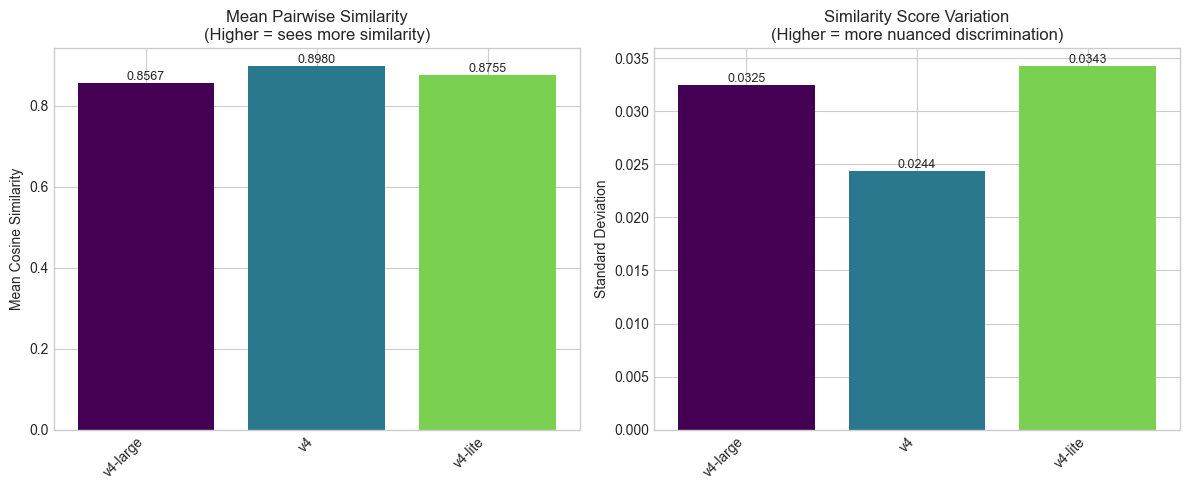

In [8]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = stats_df['Model'].tolist()
x = np.arange(len(models))

# Mean similarity
ax1 = axes[0]
bars1 = ax1.bar(x, stats_df['Mean Similarity'], color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4') for m in models], rotation=45, ha='right')
ax1.set_ylabel('Mean Cosine Similarity')
ax1.set_title('Mean Pairwise Similarity\n(Higher = sees more similarity)')
ax1.bar_label(bars1, fmt='%.4f', fontsize=9)

# Standard deviation
ax2 = axes[1]
bars2 = ax2.bar(x, stats_df['Std Dev'], color=colors)
ax2.set_xticks(x)
ax2.set_xticklabels([m.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4') for m in models], rotation=45, ha='right')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Similarity Score Variation\n(Higher = more nuanced discrimination)')
ax2.bar_label(bars2, fmt='%.4f', fontsize=9)

plt.tight_layout()
plt.show()

## Analysis 3: Cross-Model Embedding Correlation

Do the models agree on which pairs are more/less similar?

In [9]:
# Extract upper triangle similarities for each model
model_similarities = {}
for model, sim_matrix in model_sim_matrices.items():
    n = sim_matrix.shape[0]
    model_similarities[model] = sim_matrix[np.triu_indices(n, k=1)]

# Compute correlation matrix between model similarity judgments
models = list(model_similarities.keys())
n_models = len(models)
correlation_matrix = np.zeros((n_models, n_models))

for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        corr, _ = stats.pearsonr(model_similarities[m1], model_similarities[m2])
        correlation_matrix[i, j] = corr

corr_df = pd.DataFrame(
    correlation_matrix,
    index=[m.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4') for m in models],
    columns=[m.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4') for m in models]
)

print("Cross-Model Correlation of Similarity Judgments:")
corr_df

Cross-Model Correlation of Similarity Judgments:


,v4-large,v4,v4-lite
v4-large,1.000000,0.722543,0.580204
v4,0.722543,1.000000,0.771584
v4-lite,0.580204,0.771584,1.000000


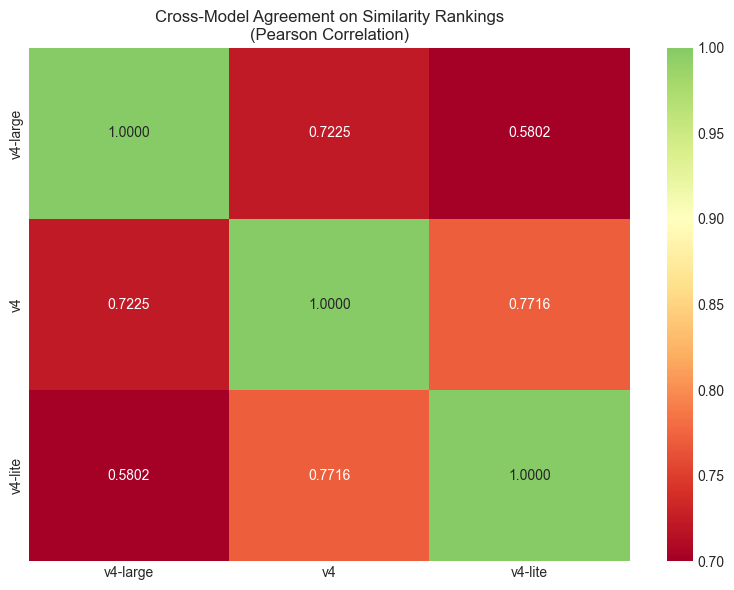

In [10]:
# Heatmap of cross-model correlation
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    corr_df,
    annot=True,
    fmt='.4f',
    cmap='RdYlGn',
    center=0.9,
    vmin=0.7,
    vmax=1.0,
    ax=ax
)

ax.set_title('Cross-Model Agreement on Similarity Rankings\n(Pearson Correlation)', fontsize=12)
plt.tight_layout()
plt.show()

## Analysis 4: Cross-Model Embedding Similarity

Since Voyage 4 models share an embedding space, how similar are the actual embedding vectors?

In [11]:
# Check if dimensions match (required for direct comparison)
dims = list(model_dims.values())
if len(set(dims)) == 1:
    print(f"✓ All models produce {dims[0]}-dimensional embeddings")
    can_compare_directly = True
else:
    print(f"✗ Models have different dimensions: {model_dims}")
    print("  Cannot directly compare embedding vectors")
    can_compare_directly = False

✓ All models produce 1024-dimensional embeddings


In [12]:
if can_compare_directly:
    # Compare embeddings for the SAME text across different models
    cross_model_sims = []
    
    models = list(model_embeddings.keys())
    for i, m1 in enumerate(models):
        for j, m2 in enumerate(models):
            if i < j:
                # Compare same-text embeddings across models
                sims = []
                for text_idx in range(len(texts)):
                    sim = cosine_similarity(
                        model_embeddings[m1][text_idx],
                        model_embeddings[m2][text_idx]
                    )
                    sims.append(sim)
                
                cross_model_sims.append({
                    'Model Pair': f"{m1.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4')} vs {m2.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4')}",
                    'Mean Similarity': np.mean(sims),
                    'Std Dev': np.std(sims),
                    'Min': np.min(sims),
                    'Max': np.max(sims)
                })
    
    cross_model_df = pd.DataFrame(cross_model_sims)
    print("Same-Text Embedding Similarity Across Models:")
    print("(How similar are embeddings for the same text from different models?)")
    cross_model_df

Same-Text Embedding Similarity Across Models:
(How similar are embeddings for the same text from different models?)


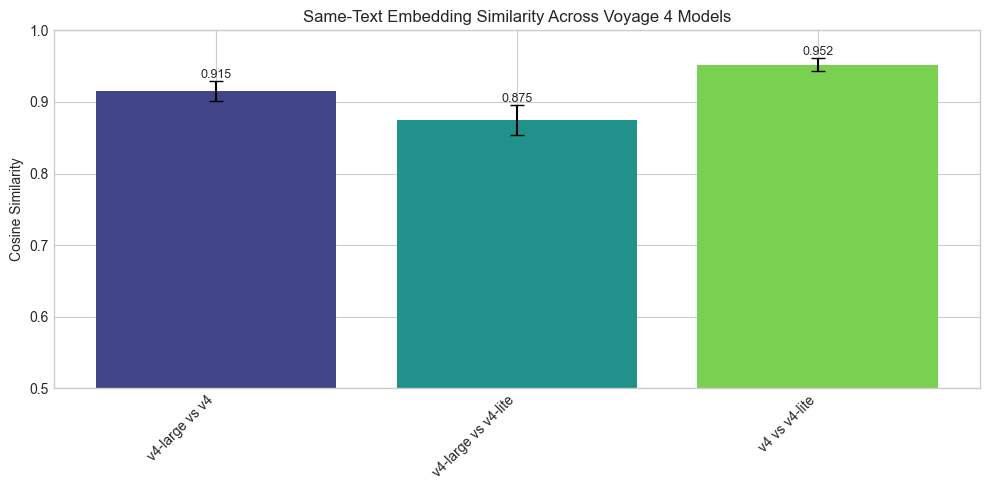

In [13]:
if can_compare_directly:
    # Visualize cross-model embedding similarity
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = np.arange(len(cross_model_df))
    bars = ax.bar(x, cross_model_df['Mean Similarity'], 
                  yerr=cross_model_df['Std Dev'], capsize=5,
                  color=plt.cm.viridis(np.linspace(0.2, 0.8, len(x))))
    
    ax.set_xticks(x)
    ax.set_xticklabels(cross_model_df['Model Pair'], rotation=45, ha='right')
    ax.set_ylabel('Cosine Similarity')
    ax.set_title('Same-Text Embedding Similarity Across Voyage 4 Models', fontsize=12)
    ax.set_ylim(0.5, 1.0)
    ax.bar_label(bars, fmt='%.3f', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Analysis 5: Diversity Metrics Comparison

In [14]:
# Compute diversity reports for each model
diversity_comparison = []

for model, embeddings in model_embeddings.items():
    report = diversity_report(embeddings)
    report['Model'] = model.replace('voyage-4-', 'v4-').replace('voyage-4', 'v4')
    diversity_comparison.append(report)

diversity_df = pd.DataFrame(diversity_comparison)
diversity_df = diversity_df[['Model', 'vendi_score', 'mean_pairwise_similarity', 'effective_rank', 'similarity_std']]
diversity_df.columns = ['Model', 'Vendi Score', 'Mean Sim', 'Effective Rank', 'Sim Std']
diversity_df

,Model,Vendi Score,Mean Sim,Effective Rank,Sim Std
0,v4-large,2.074044,0.856654,14.227024,0.032504
1,v4,1.733392,0.898040,14.149753,0.024386
2,v4-lite,1.903714,0.875545,14.027381,0.034257


## Summary & Conclusions

In [15]:
print("=" * 70)
print("CROSS-MODEL EMBEDDING ANALYSIS SUMMARY")
print("=" * 70)

print("\n📊 SIMILARITY VARIATION BY MODEL:")
print(f"   Model with highest mean similarity: {stats_df.loc[stats_df['Mean Similarity'].idxmax(), 'Model']}")
print(f"   Model with lowest mean similarity: {stats_df.loc[stats_df['Mean Similarity'].idxmin(), 'Model']}")
print(f"   Similarity range across models: {stats_df['Mean Similarity'].max() - stats_df['Mean Similarity'].min():.4f}")

print("\n📊 MODEL AGREEMENT:")
# Get off-diagonal correlations
off_diag_corrs = correlation_matrix[np.triu_indices(n_models, k=1)]
print(f"   Mean cross-model correlation: {np.mean(off_diag_corrs):.4f}")
print(f"   Min cross-model correlation: {np.min(off_diag_corrs):.4f}")
print(f"   Max cross-model correlation: {np.max(off_diag_corrs):.4f}")

if can_compare_directly:
    print("\n📊 SHARED EMBEDDING SPACE:")
    print(f"   Mean same-text similarity across models: {cross_model_df['Mean Similarity'].mean():.4f}")
    print(f"   This confirms models produce {'similar' if cross_model_df['Mean Similarity'].mean() > 0.9 else 'different'} embeddings for same text")

print("\n📊 DIVERSITY PERCEPTION:")
print(f"   Vendi Score range: {diversity_df['Vendi Score'].min():.2f} - {diversity_df['Vendi Score'].max():.2f}")
print(f"   Models perceive {'different' if diversity_df['Vendi Score'].std() > 0.5 else 'similar'} levels of diversity")

CROSS-MODEL EMBEDDING ANALYSIS SUMMARY

📊 SIMILARITY VARIATION BY MODEL:
   Model with highest mean similarity: voyage-4
   Model with lowest mean similarity: voyage-4-large
   Similarity range across models: 0.0414

📊 MODEL AGREEMENT:
   Mean cross-model correlation: 0.6914
   Min cross-model correlation: 0.5802
   Max cross-model correlation: 0.7716

📊 SHARED EMBEDDING SPACE:
   Mean same-text similarity across models: 0.9141
   This confirms models produce similar embeddings for same text

📊 DIVERSITY PERCEPTION:
   Vendi Score range: 1.73 - 2.07
   Models perceive similar levels of diversity


## Analysis 6: Similarity Score Accuracy (Relative to Large)

Treating `voyage-4-large` as the "ground truth", how much error is introduced by using smaller models?

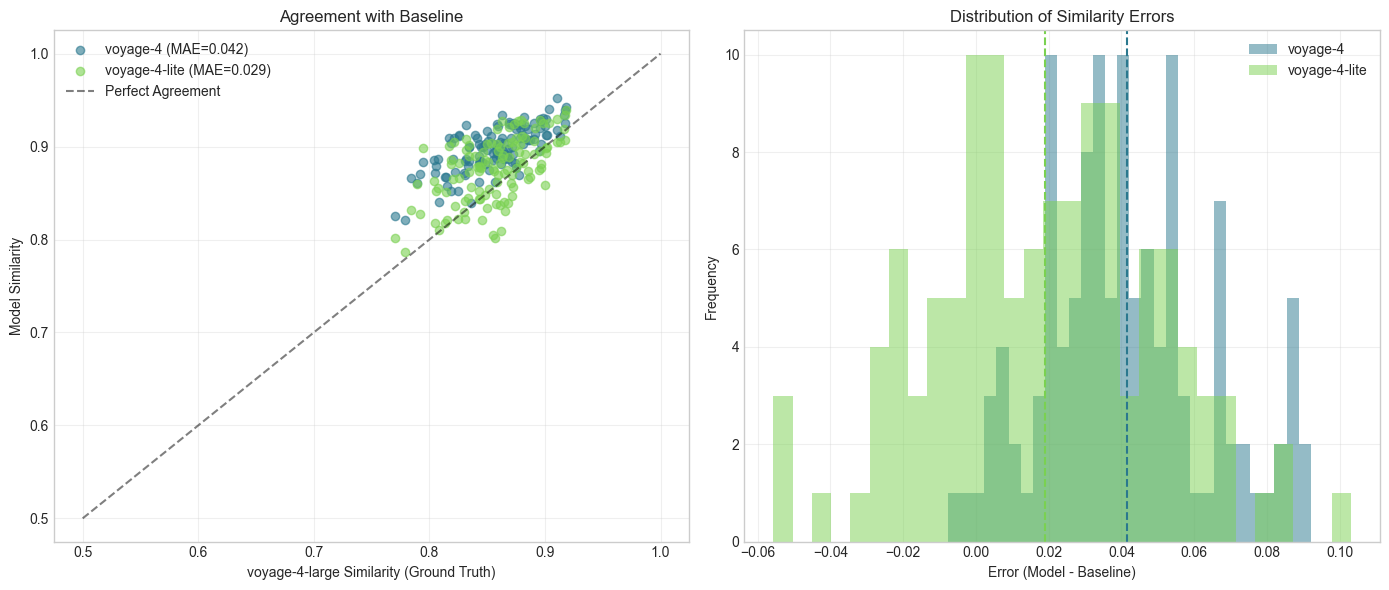


Error Metrics vs Voyage-4-Large:
           Model       MAE      RMSE      Bias  Max Error
0       voyage-4  0.041538  0.047101  0.041385   0.091991
1  voyage-4-lite  0.028692  0.035984  0.018890   0.103099


In [16]:
# Calculate errors relative to voyage-4-large
baseline_model = 'voyage-4-large'
comparison_models = [m for m in model_sim_matrices.keys() if m != baseline_model]

if baseline_model in model_sim_matrices:
    baseline_sims = model_sim_matrices[baseline_model][np.triu_indices(n, k=1)]
    
    error_data = []
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Color mapping
    model_colors = {model: colors[i] for i, model in enumerate(model_sim_matrices.keys())}
    
    for model in comparison_models:
        model_sims = model_sim_matrices[model][np.triu_indices(n, k=1)]
        errors = model_sims - baseline_sims
        
        # Metrics
        mae = np.mean(np.abs(errors))
        rmse = np.sqrt(np.mean(errors**2))
        bias = np.mean(errors)
        
        error_data.append({
            'Model': model,
            'MAE': mae,
            'RMSE': rmse,
            'Bias': bias,
            'Max Error': np.max(np.abs(errors))
        })
        
        # Scatter Plot
        axes[0].scatter(baseline_sims, model_sims, label=f"{model} (MAE={mae:.3f})", alpha=0.6, color=model_colors[model])
        
        # Error Histogram
        axes[1].hist(errors, bins=30, alpha=0.5, label=model, color=model_colors[model])
        axes[1].axvline(bias, color=model_colors[model], linestyle='--')
    
    # Scatter Layout
    axes[0].plot([0.5, 1], [0.5, 1], 'k--', alpha=0.5, label='Perfect Agreement')
    axes[0].set_xlabel(f'{baseline_model} Similarity (Ground Truth)')
    axes[0].set_ylabel('Model Similarity')
    axes[0].set_title('Agreement with Baseline')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram Layout
    axes[1].set_xlabel('Error (Model - Baseline)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Similarity Errors')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display metrics
    error_df = pd.DataFrame(error_data)
    print("\nError Metrics vs Voyage-4-Large:")
    print(error_df)
else:
    print(f"Baseline model {baseline_model} not found in results.")